In [ ]:



# Now run your Flower server
import flwr as fl
fl.server.start_server(...)




In [ ]:
pip install syft

In [ ]:
import flwr as fl
import socket
import pickle
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays

class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(self, num_rounds):
        super().__init__()
        self.num_rounds = num_rounds  # Track total rounds
        self.current_round = 0  # Track the current round

    def aggregate_fit(self, rnd, results, failures):
        """Aggregates model updates and sends them to the global server."""
        aggregated_parameters = super().aggregate_fit(rnd, results, failures)
        
        if aggregated_parameters:
            print(f"✅ Round {rnd} aggregated successfully!")
            self.current_round = rnd  # Update current round
            send_to_global_server(aggregated_parameters[0], self.current_round == self.num_rounds)

        return aggregated_parameters

def wait_for_global_server(host="127.0.0.1", port=9090):
    """Wait for the global server to connect before starting FL."""
    print("🔄 Waiting for the global server to connect...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as server_socket:
        server_socket.bind((host, port))
        server_socket.listen(1)

        conn, addr = server_socket.accept()
        with conn:
            print(f"✅ Global server connected from {addr}. Ready to start training!")

def send_to_global_server(aggregated_parameters, is_last_round, host="127.0.0.1", port=9091):
    """Send aggregated model updates to the global server, with a termination signal if last round."""
    print("📤 Sending aggregated updates to the global server...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        try:
            sock.connect((host, port))

            if is_last_round:
                message = "STOP"
                sock.sendall(message.encode())  # Send termination signal
                print("🛑 Sent termination signal to global server!")
            else:
                # Convert Parameters to ndarrays
                ndarrays = parameters_to_ndarrays(aggregated_parameters)

                # Use correct PyTorch naming convention
                parameter_names = ["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias"]
                parameters_dict = {name: param.tolist() for name, param in zip(parameter_names, ndarrays)}

                # Serialize and send
                serialized_parameters = pickle.dumps(parameters_dict)
                sock.sendall(serialized_parameters)

                print("✅ Aggregated updates sent to the global server!")
        except ConnectionRefusedError:
            print("❌ Could not connect to the global server. Make sure it is running.")

# Start the aggregation server
def start_server():
    wait_for_global_server()  # Ensure global server is connected first

    print("🔄 Waiting for clients to connect...")

    num_rounds = 5  # Define the total number of rounds
    strategy = FedAvgCustom(num_rounds)
    
    fl.server.start_server(
        server_address="0.0.0.0:8080",
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
    )

if __name__ == "__main__":
    start_server()


In [ ]:
today

In [ ]:
import flwr as fl
import socket
import pickle
import torch
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters

class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(self, num_rounds):
        super().__init__()
        self.num_rounds = num_rounds
        self.current_round = 0
        self.connected_clients = 0

    def aggregate_fit(self, rnd, results, failures):
        """Aggregates model updates and sends them to the global server."""
        aggregated_parameters = super().aggregate_fit(rnd, results, failures)

        if aggregated_parameters:
            print(f"✅ Round {rnd} aggregated successfully!")
            self.current_round = rnd  

            # Validate and send to global server
            if validate_aggregated_parameters(aggregated_parameters[0]):
                send_to_global_server(aggregated_parameters[0], self.current_round == self.num_rounds)
            else:
                print("❌ Aggregated parameters failed validation! Not sending to the global server.")

        return aggregated_parameters

def validate_aggregated_parameters(parameters):
    """Validate aggregated model parameters before sending them to the global server."""
    try:
        ndarrays = parameters_to_ndarrays(parameters)
        if len(ndarrays) == 10:  # Expecting 10 layers (512-512-256-128 MLP)
            print("✅ Aggregated parameters validated successfully!")
            return True
        else:
            print(f"❌ Invalid parameter count! Expected 10, got {len(ndarrays)}")
            return False
    except Exception as e:
        print(f"❌ Parameter validation failed: {e}")
        return False

def wait_for_global_server(host="127.0.0.1", port=9090):
    """Wait for the global server to connect before starting FL."""
    print("🔄 Waiting for the global server to connect...")
    
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as server_socket:
        server_socket.bind((host, port))
        server_socket.listen(1)

        conn, addr = server_socket.accept()
        with conn:
            print(f"✅ Global server connected from {addr}. Ready to receive model updates.")

def send_to_global_server(aggregated_parameters, is_last_round, host="127.0.0.1", port=9091):
    """Send aggregated model updates to the global server, with a termination signal if last round."""
    print("📤 Sending aggregated updates to the global server...")
    
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        try:
            sock.connect((host, port))

            if is_last_round:
                sock.sendall("STOP".encode())  
                print("🛑 Sent termination signal to global server!")
            else:
                # Convert Parameters to ndarrays
                ndarrays = parameters_to_ndarrays(aggregated_parameters)

                # PyTorch model parameters for fine-tuned architecture
                parameter_names = [
                    "fc1.weight", "fc1.bias", 
                    "fc2.weight", "fc2.bias", 
                    "fc3.weight", "fc3.bias", 
                    "fc4.weight", "fc4.bias",
                    "fc5.weight", "fc5.bias"
                ]
                
                parameters_dict = {name: param.tolist() for name, param in zip(parameter_names, ndarrays)}

                # Save aggregated model state for debugging
                torch.save(parameters_dict, "aggregated_model.pth")

                # Serialize and send
                serialized_parameters = pickle.dumps(parameters_dict)
                sock.sendall(serialized_parameters)

                print("✅ Aggregated updates sent to the global server!")
        except ConnectionRefusedError:
            print("❌ Could not connect to the global server.")

def wait_for_clients(host="0.0.0.0", port=8081, min_clients=2):
    """Wait for at least `min_clients` clients to connect before starting federated learning."""
    print(f"🔄 Waiting for at least {min_clients} clients to connect...")

    connected_clients = 0
    client_sockets = []  

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as server_socket:
        server_socket.bind((host, port))
        server_socket.listen(5)  

        while connected_clients < min_clients:
            conn, addr = server_socket.accept()
            print(f"✅ Client {connected_clients+1}/{min_clients} connected from {addr}")

            try:
                conn.settimeout(5)  # Set a timeout for response
                conn.sendall(b"PING")
                response = conn.recv(1024)
                if response.strip() == b"PONG":
                    client_sockets.append(conn)
                    connected_clients += 1
                else:
                    print("⚠️ Client did not respond correctly. Removing connection.")
                    conn.close()
            except socket.timeout:
                print("⚠️ Client did not respond in time. Removing connection.")
                conn.close()

    print("🚀 Minimum client threshold reached! Waiting for final confirmation...")
    
    # Ensure all clients are fully ready before starting training
    for sock in client_sockets:
        try:
            sock.sendall(b"READY")
            confirmation = sock.recv(1024)
            if confirmation.strip() != b"ACK":
                print("⚠️ Client did not confirm readiness. Removing connection.")
                client_sockets.remove(sock)
        except Exception as e:
            print(f"❌ Error verifying client readiness: {e}")
            client_sockets.remove(sock)

    if len(client_sockets) < min_clients:
        print("❌ Not enough ready clients. Restarting client wait...")
        return wait_for_clients(host, port, min_clients)  # Retry if necessary

    print("✅ All clients confirmed readiness. Starting federated learning now!")
    return client_sockets


def start_server():
    wait_for_global_server()  
    print("✅ Global server connected. Now waiting for clients...")

    client_sockets = wait_for_clients()  # Get connected clients

    print("🔄 Verifying active client connections before starting training...")
    
    for sock in client_sockets:
        try:
            sock.sendall(b"PING")  # Send a test message
            response = sock.recv(1024)  # Wait for client response
            if response != b"PONG":
                print("⚠️ Client did not respond correctly. Removing connection.")
                client_sockets.remove(sock)
        except Exception as e:
            print(f"❌ Error communicating with client: {e}")
            client_sockets.remove(sock)

    if len(client_sockets) < 2:
        print("❌ Not enough active clients. Restarting client wait...")
        client_sockets = wait_for_clients()  # Wait again if necessary

    print("✅ All clients verified. Starting federated learning now!")

    num_rounds = 5  
    strategy = FedAvgCustom(num_rounds)

    fl.server.start_server(
        server_address="0.0.0.0:8081",
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
    )

if __name__ == "__main__":
    start_server()


gobal form helthsheild


In [ ]:
import flwr as fl
import numpy as np
import torch
import torch.nn as nn
from typing import Dict, List, Optional, Tuple, Union
from flwr.common import Parameters, Scalar, FitRes, EvaluateRes, parameters_to_ndarrays, ndarrays_to_parameters
import os
import logging
import time
import statistics

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("server.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("FL-Server")

# ===================================
# SERVER CONFIGURATION
# ===================================
SERVER_CONFIG = {
    "num_rounds": 10,
    "min_available_clients": 2,
    "min_fit_clients": 2,
    "min_evaluate_clients": 2,
    "input_size": 15,  # Set to 15 as specified
    "aggregation_method": "fedprox",  # Using FedProx for compatibility with client
    "fedprox_mu": 0.01,
    "enable_anomaly_detection": True,
    "update_similarity_threshold": 0.85,
    "save_model_each_round": True
}

# ===================================
# MODEL DEFINITION 
# ===================================
class HealthcareModel(nn.Module):
    """Neural network model for healthcare prediction"""
    def __init__(self, input_size=15, dropout_rate=0.3):
        super(HealthcareModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

# ===================================
# SECURITY AND MONITORING UTILITIES
# ===================================
class ClientMonitor:
    """Track and evaluate client behavior for security purposes"""
    def __init__(self):
        self.client_history = {}
        self.client_trust_scores = {}
        self.anomaly_counts = {}
        
    def initialize_client(self, client_id):
        """Initialize monitoring for a new client"""
        if client_id not in self.client_history:
            self.client_history[client_id] = {
                "update_history": [],
                "accuracy_history": [],
                "anomaly_history": []
            }
            
        if client_id not in self.client_trust_scores:
            self.client_trust_scores[client_id] = 0.8  # Initial trust score
            
        if client_id not in self.anomaly_counts:
            self.anomaly_counts[client_id] = 0
    
    def record_client_update(self, client_id, parameters, metrics=None):
        """Record a client's update for monitoring"""
        self.initialize_client(client_id)
        
        # Calculate update statistics
        flattened_params = np.concatenate([p.flatten() for p in parameters])
        update_stats = {
            "mean": float(np.mean(flattened_params)),
            "std": float(np.std(flattened_params)),
            "min": float(np.min(flattened_params)),
            "max": float(np.max(flattened_params)),
            "norm": float(np.linalg.norm(flattened_params)),
            "timestamp": time.time()
        }
        
        self.client_history[client_id]["update_history"].append(update_stats)
        
        if metrics and "accuracy" in metrics:
            self.client_history[client_id]["accuracy_history"].append(float(metrics["accuracy"]))
    
    def detect_anomalies(self, client_updates):
        """Detect potentially malicious updates using statistical methods"""
        if not SERVER_CONFIG["enable_anomaly_detection"]:
            return {}
        
        anomaly_scores = {}
        clients = list(client_updates.keys())
        
        # Skip anomaly detection if only one client
        if len(clients) <= 1:
            return {client: 0.0 for client in clients}
        
        # 1. Prepare updates for analysis
        flattened_updates = {}
        for client_id, update in client_updates.items():
            flattened_updates[client_id] = np.concatenate([p.flatten() for p in update])
        
        # 2. Calculate mean update across clients
        all_updates = np.array(list(flattened_updates.values()))
        mean_update = np.mean(all_updates, axis=0)
        
        # 3. Calculate cosine similarities and update magnitudes
        for client_id, update in flattened_updates.items():
            # Cosine similarity to mean update
            cos_sim = np.dot(update, mean_update) / (np.linalg.norm(update) * np.linalg.norm(mean_update) + 1e-8)
            
            # Update magnitude
            magnitude = np.linalg.norm(update)
            
            # Mean update magnitude for comparison
            other_updates = [u for cid, u in flattened_updates.items() if cid != client_id]
            mean_magnitude = np.mean([np.linalg.norm(u) for u in other_updates])
            
            # Calculate anomaly score
            anomaly_score = 0.0
            
            # Low similarity indicates potential attack
            if cos_sim < SERVER_CONFIG["update_similarity_threshold"]:
                anomaly_score += (1 - cos_sim)
                
            # Unusual magnitude (too large or too small)
            magnitude_ratio = magnitude / mean_magnitude if mean_magnitude > 0 else 1.0
            if magnitude_ratio > 5.0 or magnitude_ratio < 0.2:
                anomaly_score += min(1.0, abs(1.0 - magnitude_ratio) / 5.0)
            
            anomaly_scores[client_id] = anomaly_score
            
            # Update anomaly history
            self.client_history[client_id]["anomaly_history"].append(anomaly_score)
            if anomaly_score > 0.5:  # Significant anomaly
                self.anomaly_counts[client_id] = self.anomaly_counts.get(client_id, 0) + 1
                
        return anomaly_scores
    
    def update_trust_scores(self, anomaly_scores):
        """Update client trust scores based on anomaly detection"""
        update_rate = 0.1  # How quickly trust scores change
        
        for client_id, anomaly_score in anomaly_scores.items():
            current_score = self.client_trust_scores.get(client_id, 0.8)
            
            # Decrease score based on anomaly severity
            if anomaly_score > 0:
                new_score = current_score * (1 - update_rate * anomaly_score)
                self.client_trust_scores[client_id] = max(0.1, new_score)
            else:
                # Slightly increase trust for good behavior
                new_score = current_score + update_rate * 0.1
                self.client_trust_scores[client_id] = min(1.0, new_score)
    
    def get_client_weights(self):
        """Get client weights based on trust scores for aggregation"""
        return self.client_trust_scores.copy()

# ===================================
# AGGREGATION METHODS
# ===================================
def federated_average(updates, weights=None):
    """Standard Federated Averaging with optional weighting"""
    if weights is None:
        weights = [1.0] * len(updates)
        
    # Normalize weights
    weights = np.array(weights) / sum(weights) if sum(weights) > 0 else np.array([1.0/len(weights)] * len(weights))
    
    # Weighted averaging
    weighted_updates = []
    for i, ((params, num_examples), weight) in enumerate(zip(updates, weights)):
        scaled_params = [np.array(param) * weight for param in params]
        weighted_updates.append(scaled_params)
    
    # Sum weighted updates
    result = [np.zeros_like(param) for param in weighted_updates[0]]
    for update in weighted_updates:
        for i, param in enumerate(update):
            result[i] += param
    
    return result

def robust_federated_aggregation(client_updates, anomaly_scores, client_weights=None):
    """Robust aggregation that filters out highly anomalous updates"""
    # Extract client IDs and updates
    client_ids = list(client_updates.keys())
    updates = [(client_updates[client_id], 1) for client_id in client_ids]
    
    # If we only have one client, return its update directly
    if len(updates) == 1:
        return updates[0][0]
    
    # Prepare weights
    weights = [1.0] * len(updates)
    
    # Factor in trust scores if available
    if client_weights:
        for i, client_id in enumerate(client_ids):
            if client_id in client_weights:
                weights[i] = client_weights[client_id]
    
    # Adjust weights based on anomaly scores
    for i, client_id in enumerate(client_ids):
        if client_id in anomaly_scores and anomaly_scores[client_id] > 0:
            penalty = min(weights[i], anomaly_scores[client_id])
            weights[i] -= penalty
    
    # Filter out clients with very low weight
    valid_indices = [i for i, w in enumerate(weights) if w > 0.2]
    
    if len(valid_indices) == 0:
        # No valid updates, use median as fallback
        params_list = [params for params, _ in updates]
        median_updates = []
        for layer_idx in range(len(params_list[0])):
            layer_updates = np.array([params[layer_idx] for params in params_list])
            median_layer = np.median(layer_updates, axis=0)
            median_updates.append(median_layer)
        return median_updates
    
    # Use valid clients only
    filtered_updates = [updates[i] for i in valid_indices]
    filtered_weights = [weights[i] for i in valid_indices]
    
    # Perform federated averaging with filtered updates
    return federated_average(filtered_updates, filtered_weights)

# ===================================
# CUSTOM FEDERATED LEARNING STRATEGY
# ===================================
class SecureFederatedStrategy(fl.server.strategy.FedAvg):
    """Enhanced strategy with security mechanisms for federated learning"""
    def __init__(
        self,
        initial_parameters,
        client_monitor=None,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.initial_parameters = initial_parameters
        self.client_monitor = client_monitor or ClientMonitor()
        self.current_round = 0
        
        # Create directories for outputs
        os.makedirs("server_logs", exist_ok=True)
        os.makedirs("server_models", exist_ok=True)
        
        logger.info(f"Initialized SecureFederatedStrategy with config: {SERVER_CONFIG}")
    
    def initialize_parameters(self, client_manager):
        """Initialize model parameters"""
        return self.initial_parameters
    
    def configure_fit(
        self, server_round, parameters, client_manager
    ):
        """Configure the next round of training"""
        self.current_round = server_round
        logger.info(f"Starting round {server_round} with {client_manager.num_available()} available clients")
        
        # Basic configuration
        config = {}
        
        # Sample clients for this round
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        return [(client, config) for client in clients]
    
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):
        """Secure aggregation of model updates"""
        if not results:
            logger.warning(f"Round {server_round}: No results to aggregate!")
            return None, {}
        
        logger.info(f"Aggregating updates from {len(results)} clients (round {server_round})")
        
        # Extract client updates and metadata
        client_updates = {}
        
        for client_proxy, fit_res in results:
            client_id = client_proxy.cid
            parameters = parameters_to_ndarrays(fit_res.parameters)
            
            # Record client metrics
            metrics = fit_res.metrics if fit_res.metrics else {}
            
            # Store updates for analysis
            client_updates[client_id] = parameters
            
            # Monitor this client
            self.client_monitor.record_client_update(client_id, parameters, metrics)
        
        # Detect anomalies in client updates
        anomaly_scores = self.client_monitor.detect_anomalies(client_updates)
        logger.info(f"Anomaly scores: {anomaly_scores}")
        
        # Update client trust scores
        self.client_monitor.update_trust_scores(anomaly_scores)
        
        # Get client weights based on trust scores
        client_weights = self.client_monitor.get_client_weights()
        
        # Use robust aggregation
        aggregated_params = robust_federated_aggregation(
            client_updates, anomaly_scores, client_weights
        )
        
        # Save metrics
        metrics = {
            "round": server_round,
            "num_clients": len(results),
            "anomalous_clients": sum(1 for score in anomaly_scores.values() if score > 0.5),
            "trust_scores": client_weights
        }
        
        # Save model if configured
        if SERVER_CONFIG["save_model_each_round"]:
            parameters = ndarrays_to_parameters(aggregated_params)
            try:
                np.save(
                    f"server_models/global_model_round_{server_round}.npy", 
                    aggregated_params
                )
                logger.info(f"Saved global model for round {server_round}")
            except Exception as e:
                logger.error(f"Failed to save model: {str(e)}")
        
        # Log metrics
        logger.info(f"Round {server_round} metrics: {metrics}")
        
        return ndarrays_to_parameters(aggregated_params), metrics
    
    def aggregate_evaluate(
        self,
        server_round,
        results,
        failures,
    ):
        """Aggregate evaluation results"""
        if not results:
            return None, {}
        
        # Extract and aggregate metrics across clients
        accuracies = [r.metrics.get("accuracy", 0.0) for _, r in results]
        losses = [r.loss for _, r in results]
        
        aggregated_metrics = {
            "round": server_round,
            "accuracy": float(sum(accuracies) / len(accuracies) if accuracies else 0.0),
            "loss": float(sum(losses) / len(losses) if losses else 0.0),
            "num_evaluate_clients": len(results)
        }
        
        logger.info(f"Evaluation metrics (round {server_round}): {aggregated_metrics}")
        
        return float(sum(losses) / len(losses) if losses else 0.0), aggregated_metrics

# ===================================
# SERVER INITIALIZATION AND STARTUP
# ===================================
def start_server():
    """Initialize and start the FL server"""
    # Create client monitor
    client_monitor = ClientMonitor()
    
    # Initialize model with input size 15
    input_size = SERVER_CONFIG["input_size"]
    global_model = HealthcareModel(input_size=input_size)
    
    # Convert PyTorch model to NumPy arrays
    global_parameters = [val.cpu().detach().numpy() for val in global_model.parameters()]
    
    # Create strategy with the client monitor
    strategy = SecureFederatedStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
        min_fit_clients=SERVER_CONFIG["min_fit_clients"],
        min_evaluate_clients=SERVER_CONFIG["min_evaluate_clients"],
        min_available_clients=SERVER_CONFIG["min_available_clients"],
        initial_parameters=ndarrays_to_parameters(global_parameters),
        client_monitor=client_monitor,
    )
    
    # Start Flower server
    logger.info(f"Starting Flower server (address: 0.0.0.0:8080)")
    fl.server.start_server(
        server_address="0.0.0.0:8080",
        strategy=strategy,
        config=fl.server.ServerConfig(num_rounds=SERVER_CONFIG["num_rounds"])
    )

# ===================================
# MAIN EXECUTION
# ===================================
if __name__ == "__main__":
    try:
        print("Starting Secure Federated Learning Server")
        print(f"Input size: {SERVER_CONFIG['input_size']}")
        print(f"Number of rounds: {SERVER_CONFIG['num_rounds']}")
        print(f"Aggregation method: {SERVER_CONFIG['aggregation_method']}")
        print(f"Anomaly detection: {'Enabled' if SERVER_CONFIG['enable_anomaly_detection'] else 'Disabled'}")
        print("")
        print("Waiting for clients to connect...")
        start_server()
    except Exception as e:
        logger.error(f"Server failed with error: {str(e)}")

In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import numpy as np
import logging
import os
import sys
import json
from typing import List, Tuple, Dict, Optional, Union
from flwr.common import Parameters, FitRes, EvaluateRes, Scalar
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters


In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import numpy as np
import logging
import os
import sys
import json
from typing import List, Tuple, Dict, Optional, Union
from flwr.common import Parameters, FitRes, EvaluateRes, Scalar
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("server.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("FraminghamServer")

# Server configuration
SERVER_CONFIG = {
    "num_rounds": 10,
    "min_available_clients": 2,
    "min_fit_clients": 2,
    "min_evaluate_clients": 2,
    "input_size": 15,  # This should match the number of features in your dataset
    "save_dir": "model_checkpoints"
}

# Model definition (must match client's model definition)
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Custom server strategy
class FraminghamStrategy(fl.server.strategy.FedAvg):
    """Federated averaging strategy for the Framingham Heart Study model"""
    
    def __init__(self, initial_parameters, save_dir=None):
        super().__init__(
            fraction_fit=1.0,  # Use all available clients for training
            fraction_evaluate=1.0,  # Use all available clients for evaluation
            min_fit_clients=SERVER_CONFIG["min_fit_clients"],
            min_evaluate_clients=SERVER_CONFIG["min_evaluate_clients"],
            min_available_clients=SERVER_CONFIG["min_available_clients"],
        )
        self.initial_parameters = initial_parameters
        self.save_dir = save_dir or "model_checkpoints"
        self.metrics_history = []
        
        # Create directory for saving models
        os.makedirs(self.save_dir, exist_ok=True)
    
    def initialize_parameters(self, client_manager):
        """Initialize model parameters"""
        return self.initial_parameters
    
    def aggregate_fit(self, server_round, results, failures):
        """Aggregate model updates from clients"""
        if not results:
            logger.warning(f"Round {server_round}: No results to aggregate!")
            return None, {}
        
        # Log aggregation info
        logger.info(f"Round {server_round}: Aggregating updates from {len(results)} clients")
        
        # Extract client metrics for logging
        client_metrics = {}
        for client_proxy, fit_res in results:
            client_id = client_proxy.cid
            metrics = fit_res.metrics if fit_res.metrics else {}
            client_metrics[client_id] = metrics
            
            # Log details for each client
            logger.info(f"Client {client_id} - Examples: {fit_res.num_examples}")
            for key, value in metrics.items():
                logger.info(f"Client {client_id} - {key}: {value}")
        
        # Use the parent class to perform aggregation 
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        
        # Add round number to metrics
        if aggregated_metrics is None:
            aggregated_metrics = {}
        aggregated_metrics["round"] = server_round
        
        # Save the aggregated model
        if aggregated_parameters is not None:
            self._save_model(server_round, aggregated_parameters)
            
            # Store metrics for history
            self.metrics_history.append({
                "round": server_round,
                "client_metrics": client_metrics,
                "aggregated_metrics": aggregated_metrics,
            })
            self._save_metrics()
        
        return aggregated_parameters, aggregated_metrics
    
    def aggregate_evaluate(self, server_round, results, failures):
        """Aggregate evaluation results from clients"""
        if not results:
            return None, {}
        
        # Log evaluation info
        logger.info(f"Round {server_round}: Aggregating evaluation from {len(results)} clients")
        
        # Extract and aggregate metrics across clients
        accuracies = [r.metrics.get("accuracy", 0.0) for _, r in results]
        losses = [r.loss for _, r in results]
        
        # Compute averages
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0
        avg_loss = sum(losses) / len(losses) if losses else 0.0
        
        # Final metrics
        metrics = {
            "accuracy": float(avg_accuracy),
            "loss": float(avg_loss),
        }
        
        logger.info(f"Round {server_round} evaluation - Accuracy: {avg_accuracy:.4f}, Loss: {avg_loss:.4f}")
        
        return avg_loss, metrics
    
    def _save_model(self, round_num, parameters):
        """Save model checkpoint"""
        try:
            # Convert parameters to numpy arrays
            numpy_params = parameters_to_ndarrays(parameters)
            
            # Save parameters as numpy file
            params_path = os.path.join(self.save_dir, f"model_round_{round_num}.npy")
            np.save(params_path, numpy_params)
            
            # Also save as PyTorch model
            model = HeartDiseaseModel(input_size=SERVER_CONFIG["input_size"])
            params_dict = zip(model.state_dict().keys(), [torch.tensor(p) for p in numpy_params])
            state_dict = {k: v for k, v in params_dict}
            model.load_state_dict(state_dict, strict=True)
            
            # Save PyTorch model
            model_path = os.path.join(self.save_dir, f"model_round_{round_num}.pt")
            torch.save(model.state_dict(), model_path)
            
            logger.info(f"Saved model checkpoint for round {round_num}")
        except Exception as e:
            logger.error(f"Failed to save model: {str(e)}")
    
    def _save_metrics(self):
        """Save training metrics history"""
        try:
            metrics_path = os.path.join(self.save_dir, "metrics_history.json")
            with open(metrics_path, "w") as f:
                json.dump(self.metrics_history, f, indent=2)
            logger.info(f"Saved metrics history to {metrics_path}")
        except Exception as e:
            logger.error(f"Failed to save metrics: {str(e)}")

def start_server(
    num_rounds=None, 
    min_clients=None, 
    input_size=None, 
    save_dir=None
):
    """Start the federated learning server"""
    # Update configuration if values provided
    if num_rounds is not None:
        SERVER_CONFIG["num_rounds"] = num_rounds
    if min_clients is not None:
        SERVER_CONFIG["min_available_clients"] = min_clients
        SERVER_CONFIG["min_fit_clients"] = min_clients
        SERVER_CONFIG["min_evaluate_clients"] = min_clients
    if input_size is not None:
        SERVER_CONFIG["input_size"] = input_size
    if save_dir is not None:
        SERVER_CONFIG["save_dir"] = save_dir
    
    # Create directory for saving models
    os.makedirs(SERVER_CONFIG["save_dir"], exist_ok=True)
    
    # Initialize model 
    model = HeartDiseaseModel(input_size=SERVER_CONFIG["input_size"])
    
    # Get model parameters as numpy arrays - FIXED: added detach() to prevent gradient error
    initial_params = [val.detach().cpu().numpy() for val in model.parameters()]
    
    # Convert to Flower parameters format
    initial_parameters = ndarrays_to_parameters(initial_params)
    
    # Create strategy
    strategy = FraminghamStrategy(
        initial_parameters=initial_parameters,
        save_dir=SERVER_CONFIG["save_dir"]
    )
    
    # Print configuration
    print("\n===== Framingham Heart Study FL Server =====")
    print(f"Rounds:          {SERVER_CONFIG['num_rounds']}")
    print(f"Minimum clients: {SERVER_CONFIG['min_available_clients']}")
    print(f"Input size:      {SERVER_CONFIG['input_size']}")
    print(f"Save directory:  {SERVER_CONFIG['save_dir']}")
    print("=============================================")
    print("\nWaiting for clients to connect...\n")
    
    # Start server
    server_config = fl.server.ServerConfig(num_rounds=SERVER_CONFIG["num_rounds"])
    return fl.server.start_server(
        server_address="0.0.0.0:8080",
        strategy=strategy,
        config=server_config
    )

if __name__ == "__main__":
    import argparse
    
    # Create argument parser
    parser = argparse.ArgumentParser(description="Framingham Heart Study FL Server")
    parser.add_argument("--rounds", type=int, default=10, help="Number of federated learning rounds")
    parser.add_argument("--min_clients", type=int, default=2, help="Minimum number of clients")
    parser.add_argument("--input_size", type=int, default=15, help="Number of input features")
    parser.add_argument("--save_dir", type=str, default="model_checkpoints", help="Directory to save models")
    
    # Handle case when running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter/IPython environment")
        start_server()
    else:
        # Parse arguments and start server
        args = parser.parse_args()
        
        try:
            start_server(
                num_rounds=args.rounds,
                min_clients=args.min_clients, 
                input_size=args.input_size,
                save_dir=args.save_dir
            )
        except Exception as e:
            logger.error(f"Server failed: {str(e)}", exc_info=True)

fed prox agg

In [4]:
import flwr as fl
import torch
import torch.nn as nn
import numpy as np
import logging
import os
import sys
import json
from typing import List, Tuple, Dict, Optional, Union
from flwr.common import Parameters, FitRes, EvaluateRes, Scalar
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters
from collections import OrderedDict

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("server.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("FraminghamServer")

# Server configuration
SERVER_CONFIG = {
    "num_rounds": 10,
    "min_available_clients": 2,
    "min_fit_clients": 2,
    "min_evaluate_clients": 2,
    "input_size": 15,  # This should match the number of features in your dataset
    "save_dir": "model_checkpoints",
    "aggregation": "fedprox",  # Options: "fedavg", "fedprox"
    "proximal_mu": 0.01  # FedProx hyperparameter (should match clients)
}

# Same model definition as the client
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Aggregation function for FedProx (server-side)
def federated_averaging(results):
    """Compute weighted average of model updates based on number of examples."""
    # Extract weights and num_examples
    weights_results = [(parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples) 
                      for _, fit_res in results]
    
    # Get the total number of examples
    total_examples = sum([num_examples for _, num_examples in weights_results])
    
    # Log the weights distribution
    logger.info(f"Aggregating from {len(weights_results)} clients with a total of {total_examples} examples")
    
    if total_examples == 0:
        # Handle edge case of no examples
        return None
    
    # Compute weighted average
    weighted_weights = []
    for weights, num_examples in weights_results:
        # Skip clients that had no examples
        if num_examples == 0:
            continue
            
        # Calculate weight for this client based on number of examples
        weight = num_examples / total_examples
        
        # Apply weighted contribution to each layer
        if not weighted_weights:  # First client, initialize weighted_weights
            weighted_weights = [layer * weight for layer in weights]
        else:  # Add to the existing weighted sum
            for i, layer in enumerate(weights):
                weighted_weights[i] += layer * weight
    
    return weighted_weights

# Custom strategy for FedProx
class FedProxStrategy(fl.server.strategy.FedAvg):
    """Custom strategy for Framingham study with FedProx support"""
    
    def __init__(self, initial_parameters, save_dir=None):
        super().__init__(
            fraction_fit=1.0,  # Use all available clients for training
            fraction_evaluate=1.0,  # Use all available clients for evaluation
            min_fit_clients=SERVER_CONFIG["min_fit_clients"],
            min_evaluate_clients=SERVER_CONFIG["min_evaluate_clients"],
            min_available_clients=SERVER_CONFIG["min_available_clients"],
        )
        self.initial_parameters = initial_parameters
        self.save_dir = save_dir or "model_checkpoints"
        self.metrics_history = []
        
        # Create directory for saving models
        os.makedirs(self.save_dir, exist_ok=True)
    
    def initialize_parameters(self, client_manager):
        """Initialize model parameters"""
        return self.initial_parameters
    
    def aggregate_fit(self, server_round, results, failures):
        """Aggregate model updates from clients"""
        if not results:
            logger.warning(f"Round {server_round}: No results to aggregate!")
            return None, {}
        
        # Log aggregation info
        logger.info(f"Round {server_round}: Aggregating updates from {len(results)} clients")
        
        # Extract client metrics for logging
        client_metrics = {}
        for client_proxy, fit_res in results:
            client_id = client_proxy.cid
            metrics = fit_res.metrics if fit_res.metrics else {}
            client_metrics[client_id] = metrics
            
            # Log details for each client
            logger.info(f"Client {client_id} - Examples: {fit_res.num_examples}")
            for key, value in metrics.items():
                logger.info(f"Client {client_id} - {key}: {value}")
        
        # Perform aggregation - same as FedAvg for the server side
        # (FedProx's main difference is in the client's loss function)
        if len(results) > 0:
            # Aggregate parameters using federated averaging
            aggregated_ndarrays = federated_averaging(results)
            
            if aggregated_ndarrays is not None:
                aggregated_parameters = ndarrays_to_parameters(aggregated_ndarrays)
                
                # Add round number to metrics
                metrics = {"round": server_round}
                
                # Calculate average metrics across all clients 
                if len(client_metrics) > 0:
                    avg_accuracy = np.mean([
                        m.get("accuracy", 0.0) for m in client_metrics.values()
                    ])
                    avg_loss = np.mean([
                        m.get("loss", 0.0) for m in client_metrics.values()
                    ])
                    metrics["accuracy"] = float(avg_accuracy)
                    metrics["loss"] = float(avg_loss)
                
                # Save the aggregated model
                self._save_model(server_round, aggregated_ndarrays)
                
                # Store metrics for history
                self.metrics_history.append({
                    "round": server_round,
                    "client_metrics": client_metrics,
                    "aggregated_metrics": metrics,
                })
                self._save_metrics()
                
                return aggregated_parameters, metrics
        
        # Fallback if aggregation fails
        return None, {}
    
    def aggregate_evaluate(self, server_round, results, failures):
        """Aggregate evaluation results from clients"""
        if not results:
            return None, {}
        
        # Log evaluation info
        logger.info(f"Round {server_round}: Aggregating evaluation from {len(results)} clients")
        
        # Extract and aggregate metrics across clients
        accuracies = [r.metrics.get("accuracy", 0.0) for _, r in results]
        losses = [r.loss for _, r in results]
        
        # Compute averages
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0
        avg_loss = sum(losses) / len(losses) if losses else 0.0
        
        # Final metrics
        metrics = {
            "accuracy": float(avg_accuracy),
            "loss": float(avg_loss),
        }
        
        logger.info(f"Round {server_round} evaluation - Accuracy: {avg_accuracy:.4f}, Loss: {avg_loss:.4f}")
        
        return avg_loss, metrics
    
    def _save_model(self, round_num, parameters):
        """Save model checkpoint"""
        try:
            # Create directory if it doesn't exist
            os.makedirs(self.save_dir, exist_ok=True)
            
            # Convert parameters to PyTorch model
            model = HeartDiseaseModel(input_size=SERVER_CONFIG["input_size"])
            
            # Fix the parameter shapes before saving
            # This ensures parameters have consistent format and avoids inhomogeneous array errors
            state_dict = OrderedDict()
            model_state_dict = model.state_dict()
            
            for i, (name, _) in enumerate(model_state_dict.items()):
                if i < len(parameters):
                    state_dict[name] = torch.tensor(parameters[i])
            
            model.load_state_dict(state_dict)
            
            # Save PyTorch model
            model_path = os.path.join(self.save_dir, f"model_round_{round_num}.pt")
            torch.save(model.state_dict(), model_path)
            
            logger.info(f"Saved model checkpoint for round {round_num}")
            
            # Also save raw parameters as NumPy arrays 
            params_path = os.path.join(self.save_dir, f"params_round_{round_num}.npz")
            np.savez(params_path, *parameters)
            
        except Exception as e:
            logger.error(f"Failed to save model: {str(e)}", exc_info=True)
    
    def _save_metrics(self):
        """Save training metrics history"""
        try:
            metrics_path = os.path.join(self.save_dir, "metrics_history.json")
            with open(metrics_path, "w") as f:
                json.dump(self.metrics_history, f, indent=2)
            logger.info(f"Saved metrics history to {metrics_path}")
        except Exception as e:
            logger.error(f"Failed to save metrics: {str(e)}")

def start_server(
    num_rounds=None, 
    min_clients=None, 
    input_size=None, 
    save_dir=None,
    aggregation=None,
    proximal_mu=None
):
    """Start the federated learning server"""
    # Update configuration if values provided
    if num_rounds is not None:
        SERVER_CONFIG["num_rounds"] = num_rounds
    if min_clients is not None:
        SERVER_CONFIG["min_available_clients"] = min_clients
        SERVER_CONFIG["min_fit_clients"] = min_clients
        SERVER_CONFIG["min_evaluate_clients"] = min_clients
    if input_size is not None:
        SERVER_CONFIG["input_size"] = input_size
    if save_dir is not None:
        SERVER_CONFIG["save_dir"] = save_dir
    if aggregation is not None:
        SERVER_CONFIG["aggregation"] = aggregation
    if proximal_mu is not None:
        SERVER_CONFIG["proximal_mu"] = proximal_mu
    
    # Create directory for saving models
    os.makedirs(SERVER_CONFIG["save_dir"], exist_ok=True)
    
    # Initialize model 
    model = HeartDiseaseModel(input_size=SERVER_CONFIG["input_size"])
    
    # Get model parameters as numpy arrays
    initial_params = [val.detach().cpu().numpy() for val in model.parameters()]
    
    # Convert to Flower parameters format
    initial_parameters = ndarrays_to_parameters(initial_params)
    
    # Create strategy (using the same strategy regardless of FedAvg or FedProx since the
    # main FedProx logic is in the client loss function)
    strategy = FedProxStrategy(
        initial_parameters=initial_parameters,
        save_dir=SERVER_CONFIG["save_dir"]
    )
    
    # Print configuration
    print(f"\n===== Framingham Heart Study FL Server ({SERVER_CONFIG['aggregation']}) =====")
    print(f"Rounds:          {SERVER_CONFIG['num_rounds']}")
    print(f"Minimum clients: {SERVER_CONFIG['min_available_clients']}")
    print(f"Input size:      {SERVER_CONFIG['input_size']}")
    print(f"Save directory:  {SERVER_CONFIG['save_dir']}")
    if SERVER_CONFIG['aggregation'] == 'fedprox':
        print(f"Proximal mu:     {SERVER_CONFIG['proximal_mu']}")
    print("=============================================")
    print("\nWaiting for clients to connect...\n")
    
    # Start server
    server_config = fl.server.ServerConfig(num_rounds=SERVER_CONFIG["num_rounds"])
    return fl.server.start_server(
        server_address="0.0.0.0:8080",
        strategy=strategy,
        config=server_config
    )

if __name__ == "__main__":
    import argparse
    
    # Create argument parser
    parser = argparse.ArgumentParser(description="Framingham Heart Study FL Server")
    parser.add_argument("--rounds", type=int, default=10, help="Number of federated learning rounds")
    parser.add_argument("--min_clients", type=int, default=2, help="Minimum number of clients")
    parser.add_argument("--input_size", type=int, default=15, help="Number of input features")
    parser.add_argument("--save_dir", type=str, default="model_checkpoints", help="Directory to save models")
    parser.add_argument("--aggregation", type=str, default="fedprox", choices=["fedavg", "fedprox"], 
                      help="Aggregation method")
    parser.add_argument("--mu", type=float, default=0.01, help="FedProx proximal term strength")
    
    # Handle case when running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter/IPython environment")
        start_server()
    else:
        # Parse arguments and start server
        args = parser.parse_args()
        
        try:
            start_server(
                num_rounds=args.rounds,
                min_clients=args.min_clients, 
                input_size=args.input_size,
                save_dir=args.save_dir,
                aggregation=args.aggregation,
                proximal_mu=args.mu
            )
        except Exception as e:
            logger.error(f"Server failed: {str(e)}", exc_info=True)

	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
2025-05-11 15:54:23,990 - flwr - WARNING - DEPRECATED FEATURE: flwr.server.start_server() is deprecated.
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower server, config: num_rounds=10, no round_timeout
2025-05-11 15:54:23,990 - flwr - INFO - Starting Flower server, config: num_rounds=10, no round_timeout

Running in Jupyter/IPython environment

===== Framingham Heart Study FL Server (fedprox) =====
Rounds:          10
Minimum clients: 2
Input size:      15
Save directory:  model_checkpoints
Proximal mu:     0.01

Waiting for clients to connect...



INFO :      configure_fit: strategy sampled 2 clients (out of 2)
2025-05-11 15:55:21,575 - flwr - INFO - configure_fit: strategy sampled 2 clients (out of 2)
INFO :      aggregate_fit: received 2 results and 0 failures
2025-05-11 15:55:24,190 - flwr - INFO - aggregate_fit: received 2 results and 0 failures
2025-05-11 15:55:24,198 - FraminghamServer - INFO - Round 1: Aggregating updates from 2 clients
2025-05-11 15:55:24,207 - FraminghamServer - INFO - Client 6ce98c84d4f142dd84e2983e3d2e0b89 - Examples: 5388
2025-05-11 15:55:24,207 - FraminghamServer - INFO - Client 6ce98c84d4f142dd84e2983e3d2e0b89 - accuracy: 0.5
2025-05-11 15:55:24,214 - FraminghamServer - INFO - Client 6ce98c84d4f142dd84e2983e3d2e0b89 - loss: 0.06062764271197712
2025-05-11 15:55:24,214 - FraminghamServer - INFO - Client 6ce98c84d4f142dd84e2983e3d2e0b89 - recall: 1.0
2025-05-11 15:55:24,214 - FraminghamServer - INFO - Client 6ce98c84d4f142dd84e2983e3d2e0b89 - f1: 0.6666666666666666
2025-05-11 15:55:24,222 - Framingham

2025-05-11 15:56:23,665 - ModelEvaluation - INFO - Using model checkpoint: model_round_30.pt
2025-05-11 15:56:23,671 - ModelEvaluation - INFO - Loaded unseendata.csv with shape (1060, 16)
2025-05-11 15:56:23,678 - ModelEvaluation - INFO - Class distribution: {0: 900, 1: 160}
2025-05-11 15:56:23,678 - ModelEvaluation - INFO - Positive class percentage: 15.09%
2025-05-11 15:56:23,695 - ModelEvaluation - INFO - Test data loaded with 1060 samples and 15 features
C:\Users\Ashan\AppData\Local\Temp\ipykernel_40876\3477735545.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could b

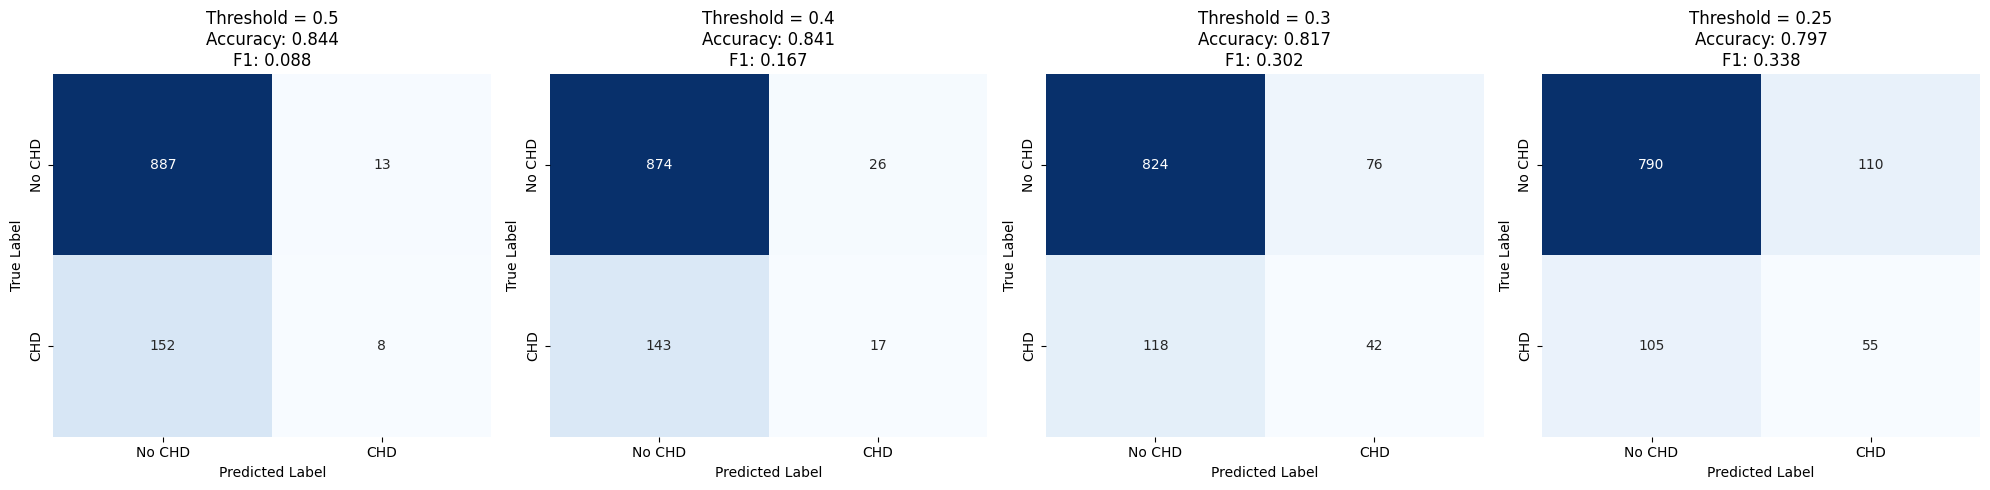

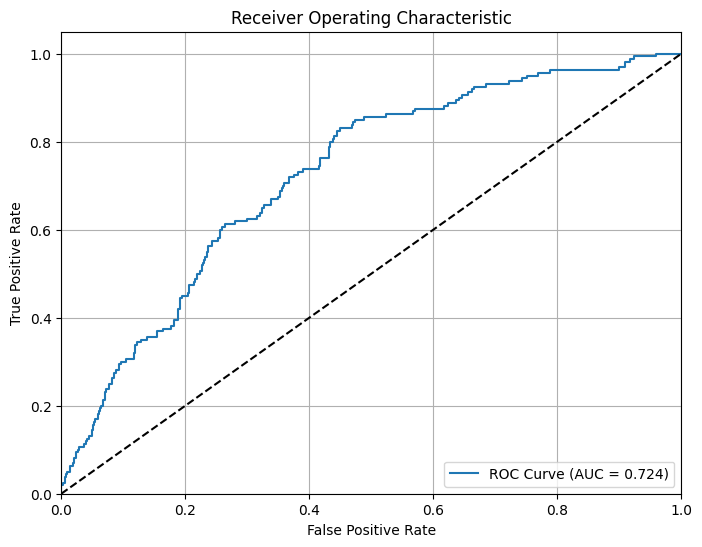

2025-05-11 15:56:26,303 - ModelEvaluation - INFO - Optimal threshold based on ROC: 0.114
2025-05-11 15:56:26,312 - ModelEvaluation - INFO - At optimal threshold - TPR: 0.831, FPR: 0.450


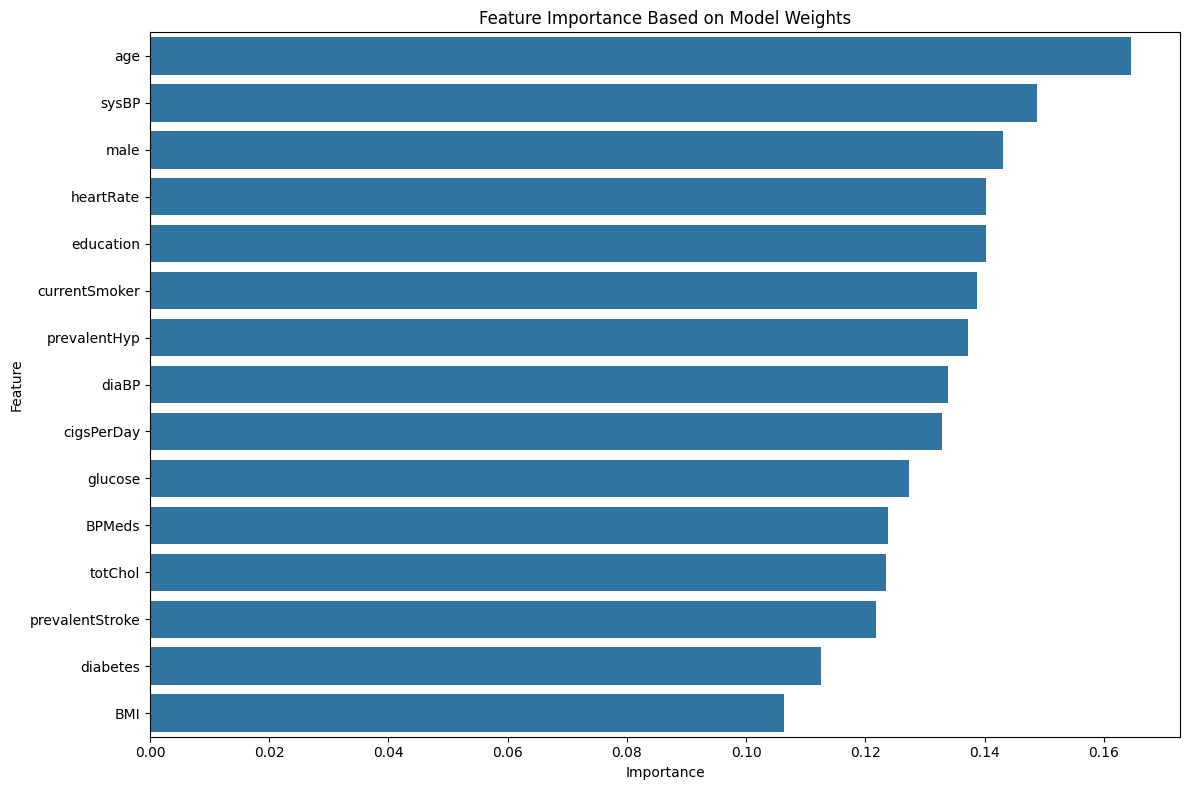

2025-05-11 15:56:27,262 - ModelEvaluation - INFO - 
Feature Importance:
2025-05-11 15:56:27,270 - ModelEvaluation - INFO -             Feature  Importance
1               age    0.164565
10            sysBP    0.148802
0              male    0.143163
13        heartRate    0.140312
2         education    0.140190
3     currentSmoker    0.138763
7      prevalentHyp    0.137229
11            diaBP    0.133834
4        cigsPerDay    0.132873
14          glucose    0.127289
5            BPMeds    0.123886
9           totChol    0.123534
6   prevalentStroke    0.121866
8          diabetes    0.112550
12              BMI    0.106367



MODEL EVALUATION SUMMARY
Threshold  Accuracy   Sensitivity  Specificity  Precision  F1 Score  
------------------------------------------------------------
0.50       0.8443     0.0500       0.9856       0.3810     0.0884    
0.40       0.8406     0.1062       0.9711       0.3953     0.1675    
0.30       0.8170     0.2625       0.9156       0.3559     0.3022    
0.25       0.7972     0.3438       0.8778       0.3333     0.3385    
Optimal threshold based on ROC curve: 0.1140


In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from collections import OrderedDict

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger("ModelEvaluation")

# Model definition (same as in training code)
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3):
        super(HeartDiseaseModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def load_and_preprocess_data(data_path):
    """Load and preprocess test data"""
    try:
        # Read CSV data
        df = pd.read_csv(data_path)
        logger.info(f"Loaded {data_path} with shape {df.shape}")
        
        # Handle missing values
        missing_values = df.isnull().sum().sum()
        if missing_values > 0:
            logger.info(f"Found {missing_values} missing values, dropping rows with missing values")
            df.dropna(inplace=True)
            logger.info(f"Shape after dropping missing values: {df.shape}")
        
        # Ensure the target column exists
        if "TenYearCHD" not in df.columns:
            raise ValueError("Target column 'TenYearCHD' not found in dataset!")
            
        # Split features and target
        X = df.drop(columns=["TenYearCHD"])
        y = df["TenYearCHD"]
        
        # Show class distribution
        class_counts = y.value_counts()
        logger.info(f"Class distribution: {class_counts.to_dict()}")
        logger.info(f"Positive class percentage: {100 * class_counts[1] / len(y):.2f}%")
        
        # Save feature names for importance analysis
        feature_names = X.columns.tolist()
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Convert to tensors
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
        
        return X_tensor, y_tensor, X.shape[1], feature_names
    
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

def load_model(model_path, input_size):
    """Load the trained model from checkpoint"""
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = HeartDiseaseModel(input_size=input_size).to(device)
        
        # Load model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        logger.info(f"Model loaded from {model_path}")
        
        return model, device
    except Exception as e:
        logger.error(f"Error loading model: {str(e)}")
        raise

def evaluate_model(model, X, y, device, thresholds=[0.5, 0.4, 0.3, 0.25]):
    """Evaluate model performance across multiple thresholds"""
    model.eval()
    X = X.to(device)
    y = y.to(device)
    
    # Get predictions
    with torch.no_grad():
        y_pred_prob = model(X)
    
    # Convert to numpy for metrics calculation
    y_true_np = y.cpu().numpy().flatten()
    y_pred_prob_np = y_pred_prob.cpu().numpy().flatten()
    
    # Calculate AUC
    auc = roc_auc_score(y_true_np, y_pred_prob_np)
    logger.info(f"ROC-AUC Score: {auc:.4f}")
    
    # Evaluate at multiple thresholds
    results = {}
    for threshold in thresholds:
        # Apply threshold
        y_pred_np = (y_pred_prob_np > threshold).astype(float)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_true_np, y_pred_np)
        
        # Calculate metrics from confusion matrix
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for positive class
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for negative class
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        # Store results
        results[threshold] = {
            'confusion_matrix': cm,
            'accuracy': accuracy,
            'sensitivity': sensitivity,  # Recall for positive class
            'specificity': specificity,  # Recall for negative class
            'precision': precision,
            'f1': f1,
        }
        
        # Print detailed results for each threshold
        logger.info(f"\nResults for threshold = {threshold}:")
        logger.info(f"Confusion Matrix:\n{cm}")
        logger.info(f"Accuracy: {accuracy:.4f}")
        logger.info(f"Sensitivity (Recall): {sensitivity:.4f}")
        logger.info(f"Specificity: {specificity:.4f}")
        logger.info(f"Precision: {precision:.4f}")
        logger.info(f"F1 Score: {f1:.4f}")
        
        # Classification report
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_true_np, y_pred_np))
    
    return results, y_true_np, y_pred_prob_np

def plot_confusion_matrices(results, thresholds):
    """Plot confusion matrices for each threshold"""
    fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))
    
    if len(thresholds) == 1:
        axes = [axes]
    
    for i, threshold in enumerate(thresholds):
        cm = results[threshold]['confusion_matrix']
        
        # Normalize confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Create confusion matrix plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_title(f'Threshold = {threshold}\nAccuracy: {results[threshold]["accuracy"]:.3f}\nF1: {results[threshold]["f1"]:.3f}')
        axes[i].set_xticklabels(['No CHD', 'CHD'])
        axes[i].set_yticklabels(['No CHD', 'CHD'])
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    """Plot ROC curve"""
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    plt.show()
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    logger.info(f"Optimal threshold based on ROC: {optimal_threshold:.3f}")
    logger.info(f"At optimal threshold - TPR: {tpr[optimal_idx]:.3f}, FPR: {fpr[optimal_idx]:.3f}")
    
    return optimal_threshold

def analyze_feature_importance(model, feature_names):
    """Extract and visualize feature importance from model weights"""
    # Get the weights from the first layer
    with torch.no_grad():
        first_layer_weights = model.layers[0].weight.cpu().numpy()
    
    # Calculate importance as the absolute mean of weights for each feature
    importance = np.abs(first_layer_weights).mean(axis=0)
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance Based on Model Weights')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    return feature_importance

def main():
    # Configuration
    model_directory = 'model_checkpoints'
    test_data_path = 'unseendata.csv'
    thresholds = [0.5, 0.4, 0.3, 0.25]  # Multiple thresholds to favor minority class
    
    # Find the latest model checkpoint
    model_files = [f for f in os.listdir(model_directory) if f.startswith('model_round_') and f.endswith('.pt')]
    if not model_files:
        logger.error(f"No model checkpoints found in {model_directory}")
        return
    
    # Get the latest round model
    latest_model = sorted(model_files, key=lambda x: int(x.split('_')[2].split('.')[0]))[-1]
    model_path = os.path.join(model_directory, latest_model)
    logger.info(f"Using model checkpoint: {latest_model}")
    
    # Load test data
    X, y, input_size, feature_names = load_and_preprocess_data(test_data_path)
    logger.info(f"Test data loaded with {X.shape[0]} samples and {input_size} features")
    
    # Load model
    model, device = load_model(model_path, input_size)
    
    # Evaluate model performance
    logger.info("Evaluating model performance...")
    results, y_true, y_pred_prob = evaluate_model(model, X, y, device, thresholds)
    
    # Plot confusion matrices
    plot_confusion_matrices(results, thresholds)
    
    # Plot ROC curve and find optimal threshold
    optimal_threshold = plot_roc_curve(y_true, y_pred_prob)
    
    # Analyze feature importance
    feature_importance = analyze_feature_importance(model, feature_names)
    logger.info("\nFeature Importance:")
    logger.info(feature_importance.to_string())
    
    # Summary table of results
    print("\n" + "="*60)
    print("MODEL EVALUATION SUMMARY")
    print("="*60)
    print(f"{'Threshold':<10} {'Accuracy':<10} {'Sensitivity':<12} {'Specificity':<12} {'Precision':<10} {'F1 Score':<10}")
    print("-"*60)
    for threshold in thresholds:
        print(f"{threshold:<10.2f} {results[threshold]['accuracy']:<10.4f} {results[threshold]['sensitivity']:<12.4f} "
              f"{results[threshold]['specificity']:<12.4f} {results[threshold]['precision']:<10.4f} {results[threshold]['f1']:<10.4f}")
    print("="*60)
    print(f"Optimal threshold based on ROC curve: {optimal_threshold:.4f}")
    print("="*60)

if __name__ == "__main__":
    main()

2025-05-11 15:57:37,928 - ImprovedModelEvaluation - INFO - Using model checkpoint: model_round_30.pt
2025-05-11 15:57:37,941 - ImprovedModelEvaluation - INFO - Loaded unseendata.csv with shape (1060, 16)
2025-05-11 15:57:37,945 - ImprovedModelEvaluation - INFO - Class distribution: {0: 900, 1: 160}
2025-05-11 15:57:37,953 - ImprovedModelEvaluation - INFO - Positive class percentage: 15.09%
2025-05-11 15:57:37,961 - ImprovedModelEvaluation - INFO - Test data loaded with 1060 samples and 15 features
2025-05-11 15:57:37,969 - ImprovedModelEvaluation - INFO - Model loaded from model_checkpoints\model_round_30.pt
2025-05-11 15:57:37,975 - ImprovedModelEvaluation - INFO - Evaluating model performance...
2025-05-11 15:57:37,986 - ImprovedModelEvaluation - INFO - ROC-AUC Score: 0.7240
2025-05-11 15:57:37,994 - ImprovedModelEvaluation - INFO - Average Precision Score: 0.3069
2025-05-11 15:57:38,003 - ImprovedModelEvaluation - INFO - 
Results for threshold = 0.5:
2025-05-11 15:57:38,003 - Improv

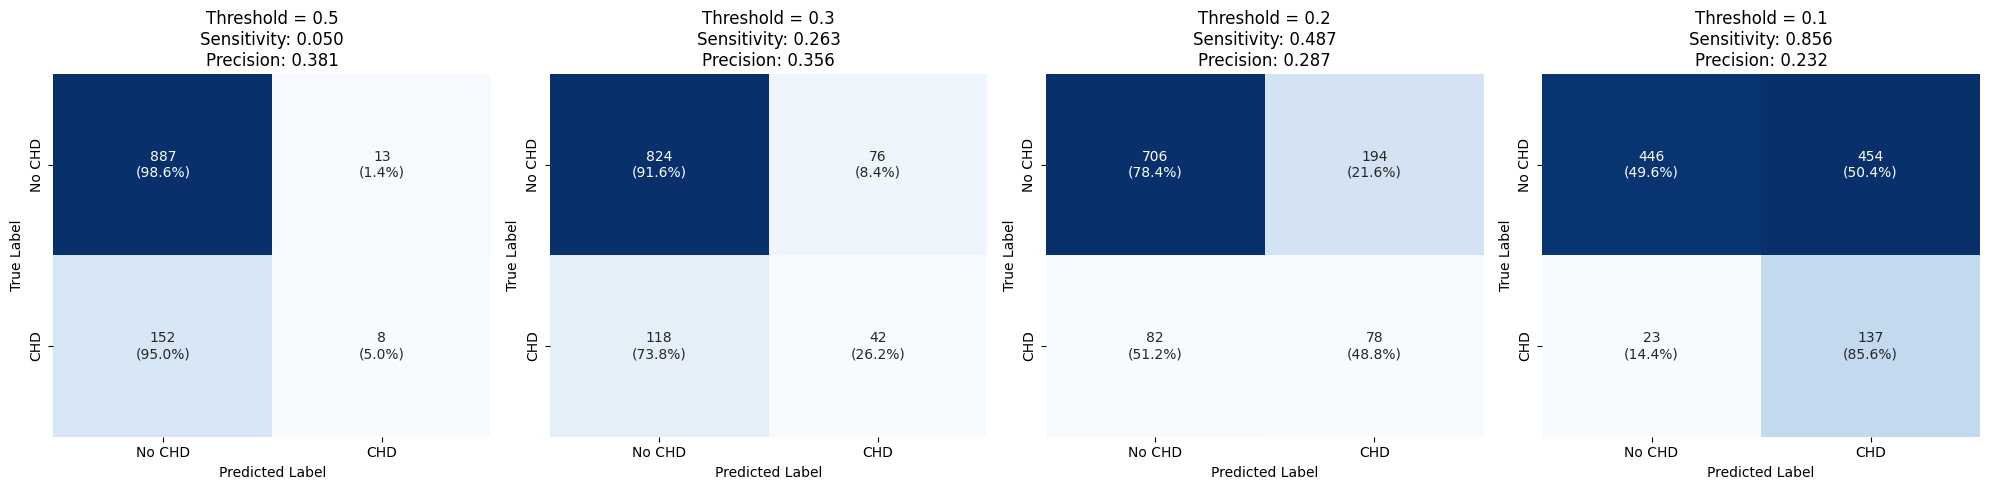

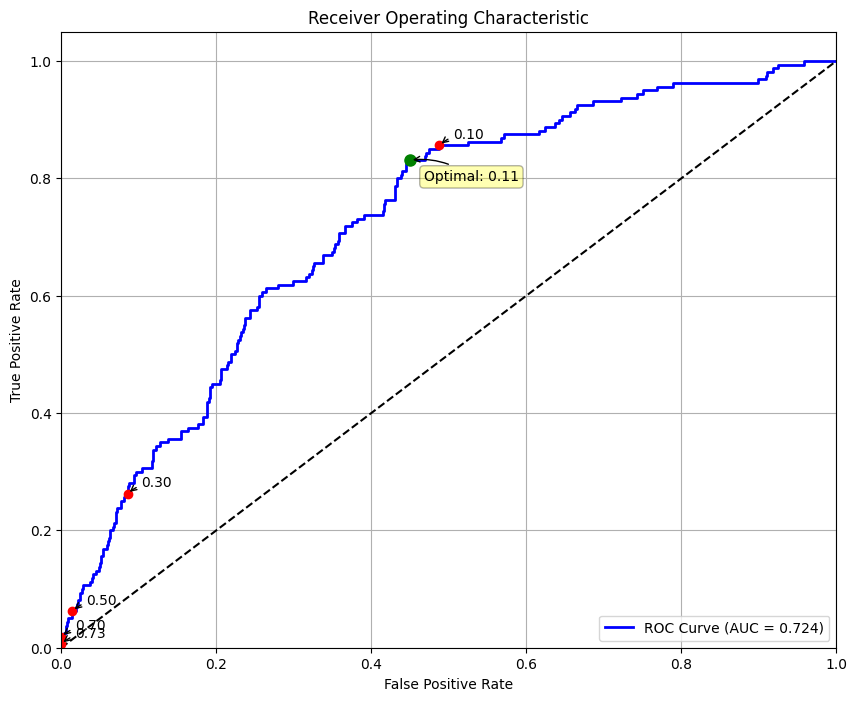

2025-05-11 15:57:40,968 - ImprovedModelEvaluation - INFO - Optimal threshold based on ROC: 0.114
2025-05-11 15:57:40,968 - ImprovedModelEvaluation - INFO - At optimal threshold - TPR: 0.831, FPR: 0.450


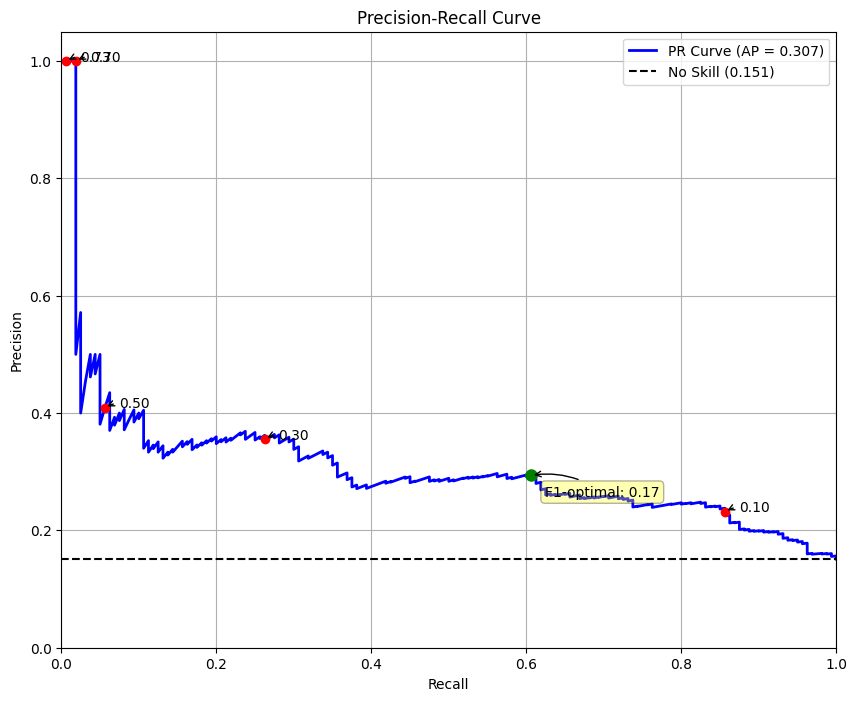

2025-05-11 15:57:42,449 - ImprovedModelEvaluation - INFO - F1-optimal threshold based on PR curve: 0.174
2025-05-11 15:57:42,449 - ImprovedModelEvaluation - INFO - At F1-optimal threshold - Precision: 0.294, Recall: 0.606


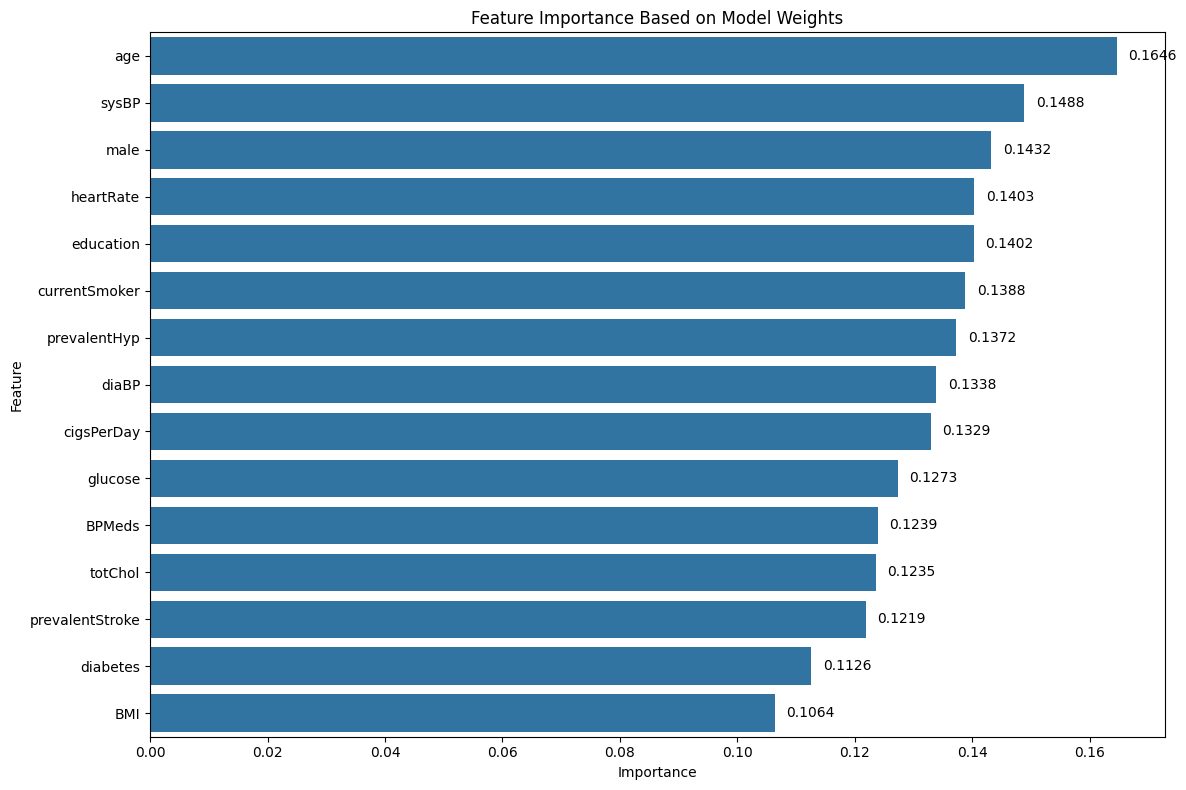

2025-05-11 15:57:43,467 - ImprovedModelEvaluation - INFO - 
Feature Importance:
2025-05-11 15:57:43,468 - ImprovedModelEvaluation - INFO - 1 age 0.164565
2025-05-11 15:57:43,474 - ImprovedModelEvaluation - INFO - 10 sysBP 0.148802
2025-05-11 15:57:43,475 - ImprovedModelEvaluation - INFO - 0 male 0.143163
2025-05-11 15:57:43,482 - ImprovedModelEvaluation - INFO - 13 heartRate 0.140312
2025-05-11 15:57:43,482 - ImprovedModelEvaluation - INFO - 2 education 0.140190
2025-05-11 15:57:43,488 - ImprovedModelEvaluation - INFO - 3 currentSmoker 0.138763
2025-05-11 15:57:43,490 - ImprovedModelEvaluation - INFO - 7 prevalentHyp 0.137229
2025-05-11 15:57:43,490 - ImprovedModelEvaluation - INFO - 11 diaBP 0.133834
2025-05-11 15:57:43,498 - ImprovedModelEvaluation - INFO - 4 cigsPerDay 0.132873
2025-05-11 15:57:43,498 - ImprovedModelEvaluation - INFO - 14 glucose 0.127289
2025-05-11 15:57:43,498 - ImprovedModelEvaluation - INFO - 5 BPMeds 0.123886
2025-05-11 15:57:43,506 - ImprovedModelEvaluation - 

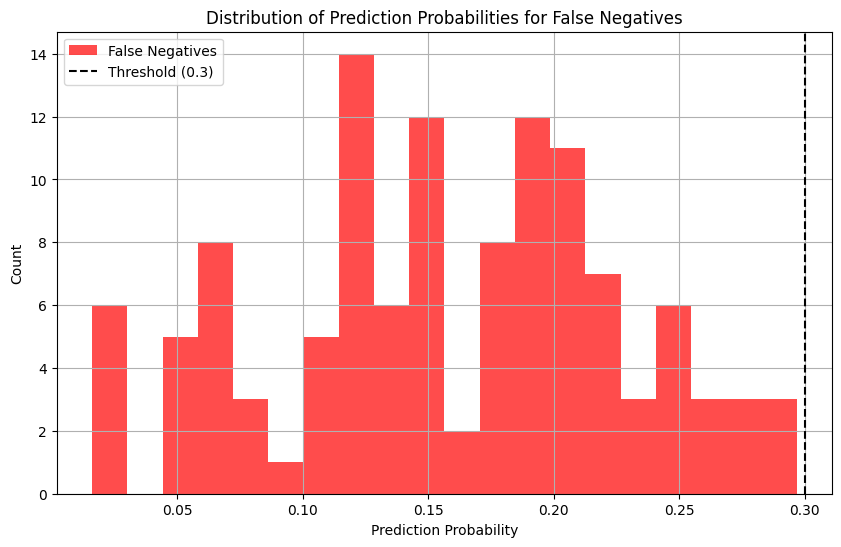


MODEL EVALUATION SUMMARY
Threshold  Accuracy   Sensitivity  Specificity  Precision  F1 Score   Clinical  
--------------------------------------------------------------------------------
0.50       0.8443     0.0500       0.9856       0.3810     0.0884     0.1603    
0.30       0.8170     0.2625       0.9156       0.3559     0.3022     0.2936    
0.20       0.7396     0.4875       0.7844       0.2868     0.3611     0.4206    
0.10       0.5500     0.8562       0.4956       0.2318     0.3648     0.6481    
Optimal threshold based on ROC curve: 0.1140
Optimal threshold based on PR curve: 0.1741
Recommended clinical threshold: 0.1
At this threshold:
  - Sensitivity: 0.8562
  - Specificity: 0.4956
  - Precision: 0.2318
  - F1 Score: 0.3648


In [6]:
# improved_evaluation.py
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from collections import OrderedDict

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger("ImprovedModelEvaluation")

# Model definition (same as in training code)
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3):
        super(HeartDiseaseModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def load_and_preprocess_data(data_path):
    """Load and preprocess test data"""
    try:
        # Read CSV data
        df = pd.read_csv(data_path)
        logger.info(f"Loaded {data_path} with shape {df.shape}")
        
        # Handle missing values
        missing_values = df.isnull().sum().sum()
        if missing_values > 0:
            logger.info(f"Found {missing_values} missing values, dropping rows with missing values")
            df.dropna(inplace=True)
            logger.info(f"Shape after dropping missing values: {df.shape}")
        
        # Ensure the target column exists
        if "TenYearCHD" not in df.columns:
            raise ValueError("Target column 'TenYearCHD' not found in dataset!")
            
        # Split features and target
        X = df.drop(columns=["TenYearCHD"])
        y = df["TenYearCHD"]
        
        # Show class distribution
        class_counts = y.value_counts()
        logger.info(f"Class distribution: {class_counts.to_dict()}")
        logger.info(f"Positive class percentage: {100 * class_counts[1] / len(y):.2f}%")
        
        # Save feature names for importance analysis
        feature_names = X.columns.tolist()
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Convert to tensors
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
        
        return X_tensor, y_tensor, X.shape[1], feature_names
    
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

def load_model(model_path, input_size):
    """Load the trained model from checkpoint"""
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = HeartDiseaseModel(input_size=input_size).to(device)
        
        # Load model weights with weights_only=True to avoid security warnings
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        logger.info(f"Model loaded from {model_path}")
        
        return model, device
    except Exception as e:
        logger.error(f"Error loading model: {str(e)}")
        raise

def evaluate_model(model, X, y, device, thresholds=[0.5, 0.3, 0.2, 0.1]):
    """Evaluate model performance across multiple thresholds"""
    model.eval()
    X = X.to(device)
    y = y.to(device)
    
    # Get predictions
    with torch.no_grad():
        y_pred_prob = model(X)
    
    # Convert to numpy for metrics calculation
    y_true_np = y.cpu().numpy().flatten()
    y_pred_prob_np = y_pred_prob.cpu().numpy().flatten()
    
    # Calculate AUC
    auc = roc_auc_score(y_true_np, y_pred_prob_np)
    logger.info(f"ROC-AUC Score: {auc:.4f}")
    
    # Calculate Average Precision (AP)
    ap = average_precision_score(y_true_np, y_pred_prob_np)
    logger.info(f"Average Precision Score: {ap:.4f}")
    
    # Evaluate at multiple thresholds
    results = {}
    for threshold in thresholds:
        # Apply threshold
        y_pred_np = (y_pred_prob_np > threshold).astype(float)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_true_np, y_pred_np)
        
        # Calculate metrics from confusion matrix
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for positive class
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for negative class
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        # Clinical relevance metric: balance between sensitivity and PPV
        # High sensitivity is prioritized for medical screening
        clinical_utility = (2 * sensitivity + precision) / 3 if (sensitivity + precision) > 0 else 0
        
        # Store results
        results[threshold] = {
            'confusion_matrix': cm,
            'accuracy': accuracy,
            'sensitivity': sensitivity,  # Recall for positive class
            'specificity': specificity,  # Recall for negative class
            'precision': precision,
            'f1': f1,
            'clinical_utility': clinical_utility
        }
        
        # Print detailed results for each threshold
        logger.info(f"\nResults for threshold = {threshold}:")
        logger.info(f"Confusion Matrix:\n{cm}")
        logger.info(f"Accuracy: {accuracy:.4f}")
        logger.info(f"Sensitivity (Recall): {sensitivity:.4f}")
        logger.info(f"Specificity: {specificity:.4f}")
        logger.info(f"Precision: {precision:.4f}")
        logger.info(f"F1 Score: {f1:.4f}")
        logger.info(f"Clinical Utility: {clinical_utility:.4f}")
        
        # Classification report
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_true_np, y_pred_np))
    
    return results, y_true_np, y_pred_prob_np

def plot_confusion_matrices(results, thresholds):
    """Plot confusion matrices for each threshold"""
    fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))
    
    if len(thresholds) == 1:
        axes = [axes]
    
    for i, threshold in enumerate(thresholds):
        cm = results[threshold]['confusion_matrix']
        
        # Calculate percentages for annotation
        tn, fp, fn, tp = cm.ravel()
        total_neg = tn + fp
        total_pos = fn + tp
        
        # Create annotation texts with percentages
        annot = np.array([
            [f"{tn}\n({tn/total_neg*100:.1f}%)", f"{fp}\n({fp/total_neg*100:.1f}%)"],
            [f"{fn}\n({fn/total_pos*100:.1f}%)", f"{tp}\n({tp/total_pos*100:.1f}%)"]
        ])
        
        # Create confusion matrix plot
        sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", cbar=False, ax=axes[i])
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_title(f'Threshold = {threshold}\nSensitivity: {results[threshold]["sensitivity"]:.3f}\nPrecision: {results[threshold]["precision"]:.3f}')
        axes[i].set_xticklabels(['No CHD', 'CHD'])
        axes[i].set_yticklabels(['No CHD', 'CHD'])
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    
    # Add threshold annotations
    threshold_indices = []
    for t in [0.9, 0.7, 0.5, 0.3, 0.1]:
        # Find closest threshold
        idx = np.argmin(np.abs(thresholds - t))
        threshold_indices.append(idx)
    
    for idx in threshold_indices:
        plt.plot(fpr[idx], tpr[idx], 'ro')
        plt.annotate(f"{thresholds[idx]:.2f}", 
                    (fpr[idx], tpr[idx]), 
                    xytext=(10, 5), 
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
    
    # Highlight the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=8)
    plt.annotate(f"Optimal: {thresholds[optimal_idx]:.2f}", 
                (fpr[optimal_idx], tpr[optimal_idx]), 
                xytext=(10, -15), 
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    plt.show()
    
    # Find optimal threshold
    optimal_threshold = thresholds[optimal_idx]
    logger.info(f"Optimal threshold based on ROC: {optimal_threshold:.3f}")
    logger.info(f"At optimal threshold - TPR: {tpr[optimal_idx]:.3f}, FPR: {fpr[optimal_idx]:.3f}")
    
    return optimal_threshold

def plot_precision_recall_curve(y_true, y_pred_prob):
    """Plot Precision-Recall curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AP = {ap:.3f})')
    
    # Add threshold annotations
    threshold_indices = []
    # Skip the last threshold which is 0
    thresholds = np.append(thresholds, 0)
    for t in [0.9, 0.7, 0.5, 0.3, 0.1]:
        # Find closest threshold
        idx = np.argmin(np.abs(thresholds - t))
        threshold_indices.append(idx)
    
    for idx in threshold_indices:
        plt.plot(recall[idx], precision[idx], 'ro')
        plt.annotate(f"{thresholds[idx]:.2f}", 
                    (recall[idx], precision[idx]), 
                    xytext=(10, 0), 
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
    
    # Find F1-optimal threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    plt.plot(recall[optimal_idx], precision[optimal_idx], 'go', markersize=8)
    plt.annotate(f"F1-optimal: {optimal_threshold:.2f}", 
                (recall[optimal_idx], precision[optimal_idx]), 
                xytext=(10, -15), 
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    # Add no-skill classifier line
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', label=f'No Skill ({no_skill:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig('precision_recall_curve.png')
    plt.show()
    
    logger.info(f"F1-optimal threshold based on PR curve: {optimal_threshold:.3f}")
    logger.info(f"At F1-optimal threshold - Precision: {precision[optimal_idx]:.3f}, Recall: {recall[optimal_idx]:.3f}")
    
    return optimal_threshold

def analyze_feature_importance(model, feature_names):
    """Extract and visualize feature importance from model weights"""
    # Get the weights from the first layer
    with torch.no_grad():
        first_layer_weights = model.layers[0].weight.cpu().numpy()
    
    # Calculate importance as the absolute mean of weights for each feature
    importance = np.abs(first_layer_weights).mean(axis=0)
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance)
    
    # Add value labels to bars
    for i, v in enumerate(feature_importance['Importance']):
        ax.text(v + 0.002, i, f"{v:.4f}", va='center')
    
    plt.title('Feature Importance Based on Model Weights')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    return feature_importance

def find_misclassified_cases(model, X, y, device, threshold=0.3):
    """Find and analyze misclassified cases, especially false negatives"""
    model.eval()
    X = X.to(device)
    y = y.to(device)
    
    # Get predictions
    with torch.no_grad():
        y_pred_prob = model(X)
    
    # Apply threshold
    y_pred = (y_pred_prob > threshold).float()
    
    # Find misclassified indices
    misclassified = (y_pred != y).cpu().numpy().flatten()
    false_negatives = ((y_pred == 0) & (y == 1)).cpu().numpy().flatten()
    false_positives = ((y_pred == 1) & (y == 0)).cpu().numpy().flatten()
    
    # Return to numpy for analysis
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy().flatten()
    y_pred_prob_np = y_pred_prob.cpu().numpy().flatten()
    
    logger.info(f"Total misclassified cases: {np.sum(misclassified)}")
    logger.info(f"False negatives (missed CHD): {np.sum(false_negatives)}")
    logger.info(f"False positives (false alarms): {np.sum(false_positives)}")
    
    # Analyze probability distribution of misclassified cases
    if np.sum(false_negatives) > 0:
        fn_probs = y_pred_prob_np[false_negatives]
        logger.info(f"False negative probability stats:")
        logger.info(f"  Mean: {np.mean(fn_probs):.4f}")
        logger.info(f"  Median: {np.median(fn_probs):.4f}")
        logger.info(f"  Min: {np.min(fn_probs):.4f}")
        logger.info(f"  Max: {np.max(fn_probs):.4f}")
        
        # Plot the probability distribution
        plt.figure(figsize=(10, 6))
        plt.hist(fn_probs, bins=20, alpha=0.7, color='red', label='False Negatives')
        plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
        plt.xlabel('Prediction Probability')
        plt.ylabel('Count')
        plt.title('Distribution of Prediction Probabilities for False Negatives')
        plt.legend()
        plt.grid(True)
        plt.savefig('false_negative_distribution.png')
        plt.show()
    
    return {
        'misclassified_indices': np.where(misclassified)[0],
        'false_negative_indices': np.where(false_negatives)[0],
        'false_positive_indices': np.where(false_positives)[0],
        'probabilities': y_pred_prob_np
    }

def main():
    # Configuration
    model_directory = 'model_checkpoints'
    test_data_path = 'unseendata.csv'
    thresholds = [0.5, 0.3, 0.2, 0.1]  # Multiple thresholds to favor minority class
    
    # Find the latest model checkpoint
    model_files = [f for f in os.listdir(model_directory) if f.startswith('model_round_') and f.endswith('.pt')]
    if not model_files:
        logger.error(f"No model checkpoints found in {model_directory}")
        return
    
    # Get the latest round model
    latest_model = sorted(model_files, key=lambda x: int(x.split('_')[2].split('.')[0]))[-1]
    model_path = os.path.join(model_directory, latest_model)
    logger.info(f"Using model checkpoint: {latest_model}")
    
    # Load test data
    X, y, input_size, feature_names = load_and_preprocess_data(test_data_path)
    logger.info(f"Test data loaded with {X.shape[0]} samples and {input_size} features")
    
    # Load model
    model, device = load_model(model_path, input_size)
    
    # Evaluate model performance
    logger.info("Evaluating model performance...")
    results, y_true, y_pred_prob = evaluate_model(model, X, y, device, thresholds)
    
    # Plot confusion matrices
    plot_confusion_matrices(results, thresholds)
    
    # Plot ROC curve and find optimal threshold
    roc_optimal_threshold = plot_roc_curve(y_true, y_pred_prob)
    
    # Plot PR curve and find optimal threshold
    pr_optimal_threshold = plot_precision_recall_curve(y_true, y_pred_prob)
    
    # Analyze feature importance
    feature_importance = analyze_feature_importance(model, feature_names)
    logger.info("\nFeature Importance:")
    for i, row in feature_importance.iterrows():
        logger.info(f"{i} {row['Feature']} {row['Importance']:.6f}")
    
    # Find misclassified cases
    misclassified_results = find_misclassified_cases(model, X, y, device, threshold=0.3)
    
    # Summary table of results
    print("\n" + "="*80)
    print("MODEL EVALUATION SUMMARY")
    print("="*80)
    print(f"{'Threshold':<10} {'Accuracy':<10} {'Sensitivity':<12} {'Specificity':<12} {'Precision':<10} {'F1 Score':<10} {'Clinical':<10}")
    print("-"*80)
    for threshold in thresholds:
        print(f"{threshold:<10.2f} {results[threshold]['accuracy']:<10.4f} {results[threshold]['sensitivity']:<12.4f} "
              f"{results[threshold]['specificity']:<12.4f} {results[threshold]['precision']:<10.4f} {results[threshold]['f1']:<10.4f} "
              f"{results[threshold]['clinical_utility']:<10.4f}")
    print("="*80)
    print(f"Optimal threshold based on ROC curve: {roc_optimal_threshold:.4f}")
    print(f"Optimal threshold based on PR curve: {pr_optimal_threshold:.4f}")
    print("="*80)
    
    # Recommended clinical threshold based on use case
    # For medical screening, we prioritize sensitivity (recall)
    clinical_thresholds = {}
    for threshold in thresholds:
        # Clinical utility score (weighted toward sensitivity)
        clinical_thresholds[threshold] = (2 * results[threshold]['sensitivity'] + results[threshold]['precision']) / 3
    
    best_clinical_threshold = max(clinical_thresholds.items(), key=lambda x: x[1])[0]
    print(f"Recommended clinical threshold: {best_clinical_threshold}")
    print(f"At this threshold:")
    print(f"  - Sensitivity: {results[best_clinical_threshold]['sensitivity']:.4f}")
    print(f"  - Specificity: {results[best_clinical_threshold]['specificity']:.4f}")
    print(f"  - Precision: {results[best_clinical_threshold]['precision']:.4f}")
    print(f"  - F1 Score: {results[best_clinical_threshold]['f1']:.4f}")
    print("="*80)

if __name__ == "__main__":
    main()

In [ ]:
# fl_server.py

import torch
import torch.nn as nn
from collections import OrderedDict
import socket
import threading
import pickle
import time
import os

# --- 1) Model definition (must match client) ---
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        return self.sigmoid(self.fc3(x))

# --- 2) Global model setup ---
INPUT_SIZE = 19   # <-- MUST match client’s feature count (original + engineered)
global_model = HeartDiseaseModel(INPUT_SIZE)

# --- 3) Aggregation & checkpointing ---
CHECKPOINT_DIR = "model_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def aggregate_models(client_states, client_samples):
    total = sum(client_samples)
    if total == 0: return
    new_state = OrderedDict(
        (k, torch.zeros_like(v)) for k,v in global_model.state_dict().items()
    )
    for state, n in zip(client_states, client_samples):
        w = n / total
        for k, v in state.items():
            new_state[k] += v.to(new_state[k].device) * w
    global_model.load_state_dict(new_state)

def save_checkpoint(round_num):
    path = os.path.join(CHECKPOINT_DIR, f"model_round_{round_num}.pt")
    torch.save(global_model.state_dict(), path)
    print(f"[Server] Saved checkpoint: {path}")

# --- 4) Federated server with sockets ---
class FLServer:
    def __init__(self, host="localhost", port=8765, min_clients=2, rounds=10):
        self.addr = (host, port)
        self.min_clients = min_clients
        self.total_rounds = rounds

        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.sock.bind(self.addr)
        self.clients = {}        # client_id -> socket
        self.client_states = {}  # client_id -> state_dict
        self.client_samples = {} # client_id -> num_samples
        self.round = 0
        self.lock = threading.Lock()

    def start(self):
        print(f"[Server] Listening on {self.addr[0]}:{self.addr[1]}")
        self.sock.listen()
        threading.Thread(target=self._accept_loop, daemon=True).start()
        self._federated_loop()

    def _accept_loop(self):
        while True:
            conn, addr = self.sock.accept()
            client_id = conn.recv(1024).decode().strip()
            print(f"[Server] {client_id} connected from {addr}")
            with self.lock:
                self.clients[client_id] = conn
            threading.Thread(target=self._handle_client, args=(client_id,conn), daemon=True).start()

    def _handle_client(self, cid, conn):
        buf = b""
        try:
            while True:
                data = conn.recv(1024)
                if not data: break
                buf += data
                while b"\n" in buf:
                    line, buf = buf.split(b"\n",1)
                    msg = line.decode()
                    if msg=="PING":
                        conn.sendall(b"PONG\n")
                    elif msg=="GET_MODEL":
                        payload = pickle.dumps(global_model.state_dict())
                        conn.sendall(f"{len(payload)}\n".encode())
                        conn.sendall(payload)
                    elif msg=="GET_ROUND":
                        conn.sendall(f"{self.round}\n".encode())
                    elif msg.startswith("SUBMIT_MODEL:"):
                        length = int(msg.split(":",1)[1])
                        conn.sendall(b"READY\n")
                        data=b""
                        while len(data)<length:
                            chunk=conn.recv(length-len(data))
                            if not chunk: raise IOError("conn closed")
                            data+=chunk
                        pkg=pickle.loads(data)
                        with self.lock:
                            self.client_states[cid]=pkg["model"]
                            self.client_samples[cid]=pkg["num_samples"]
                        conn.sendall(b"SUCCESS\n")
                        print(f"[Server] Received {cid} update ({pkg['num_samples']} samples)")
                    else:
                        conn.sendall(b"UNKNOWN\n")
        except Exception as e:
            print(f"[Server] {cid} error: {e}")
        finally:
            with self.lock:
                self.clients.pop(cid, None)
                self.client_states.pop(cid, None)
                self.client_samples.pop(cid, None)
            conn.close()
            print(f"[Server] {cid} disconnected")

    def _federated_loop(self):
        # wait for min clients
        while True:
            with self.lock:
                if len(self.clients)>=self.min_clients: break
            print(f"[Server] waiting for {self.min_clients} clients (have {len(self.clients)})...")
            time.sleep(2)

        print(f"[Server] Starting FL for {self.total_rounds} rounds")
        for r in range(1, self.total_rounds+1):
            self.round = r
            print(f"\n[Server] === Round {r}/{self.total_rounds} ===")
            start=time.time()
            # wait submissions
            while True:
                with self.lock:
                    ready = len(self.client_states)
                if ready>=self.min_clients: break
                if time.time()-start>60:
                    print("[Server] Round timeout")
                    break
                time.sleep(1)
                print(f"[Server] collected {ready}/{self.min_clients} updates...")
            # aggregate
            with self.lock:
                if len(self.client_states)>=self.min_clients:
                    aggregate_models(list(self.client_states.values()),
                                     list(self.client_samples.values()))
                    save_checkpoint(r)
                    print(f"[Server] Aggregated {len(self.client_states)} clients")
                else:
                    print("[Server] Not enough updates—skipping aggregation")
                # clear for next round
                self.client_states.clear()
                self.client_samples.clear()
            time.sleep(2)

        print("[Server] Federated learning complete. Shutting down.")
        self.sock.close()

if __name__=="__main__":
    FLServer().start()


[Server] Listening on localhost:8765
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting for 2 clients (have 0)...
[Server] waiting 